# __Symmetry analysis. Pysical adequacy__

### __Calculators definitions__

In [1]:
# ANI


# import the calculators
from torch import device
from torchani.models import ANI1x, ANI2x, ANI1ccx

ani1x_calc = ANI1x().ase()
ani1ccx_calc = ANI1ccx().ase()
ani2x_calc = ANI2x().ase()

# device type can defined via torch and parsed to the model via .to() method
#device_ = device('cpu')
#model_ = ANI1x(periodic_table_index=True).to(device_).double().ase()


# MACE
from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float32", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float32'
    )

# ORB

from orb_models.forcefield.pretrained import orb_v2, orb_d3_v2
from orb_models.forcefield.calculator import ORBCalculator

orbff_v2 = orb_v2(device='cpu')
orb_calc_v2 = ORBCalculator(orbff_v2, device='cpu')

orbff_d3_v2 = orb_d3_v2(device='cpu')
orb_calc_d3_v2 = ORBCalculator(orbff_d3_v2, device='cpu')


CALC_NAME = 'ALL'

/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indice

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

In [36]:
# define the calculators
calculator_list = [ani1x_calc, ani1ccx_calc, ani2x_calc, macemp, maceoff, orb_calc_v2, orb_calc_d3_v2]
calculator_names = ['ANI-1x', 'ANI-1ccx', 'ANI-2x', 'MACE-MP', 'MACE-OFF', 'ORB-V2', 'ORB-D3-V2']
calculator_colors = ['darkviolet', 'crimson', 'deeppink', 'darkgreen', 'mediumseagreen', 'royalblue', 'darkblue']

color_dict = {
    'ANI-1x': 'darkviolet', 
    'ANI-1ccx': 'crimson', 
    'ANI-2x': 'deeppink', 
    'MACE-MP': 'darkgreen', 
    'MACE-OFF':  'mediumseagreen', 
    'ORB-V2': 'royalblue', 
    'ORB-D3-V2': 'darkblue',
}

## __General imports__

In [3]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase import Atoms
from ase.visualize import view
from ase.build import molecule
from ase.io import write, read
from ase.io import Trajectory, trajectory
from ase import build
from ase.data.pubchem import pubchem_atoms_search

In [4]:
def compute_com_torque(atoms):
    '''
    Compute the total internal torque wrt the center of mass of the molecule
    Note that the total tau is invariant wrt the change of coordinate system. 
    '''
    
    # copy the object (just to be safe)
    molecule_ = atoms

    # compute the com and center the molecule there
    com = molecule_.get_center_of_mass()
    molecule_.center(about=com)
    positions = molecule_.get_positions()
    forces = molecule_.get_forces()

    torques = []
    for i in range(len(positions)):
        tau = np.cross(positions[i], forces[i])
        torques.append(tau)

    total_tau = np.array(torques).sum()
    #print(f'total torque (at com)\t{total_tau}')

    return total_tau

In [32]:
def evaluate_rotation(molecule, calculator_list, mol_name, calc_name, verbose=False, rot_angle='z', visualize=False, group=[], compute_torque=False, cosan=False, resolution=None):

    # create the working directory
    work_dir = os.path.join(os.curdir, 'symmetries',  mol_name)
    if not os.path.isdir(work_dir):
        os.makedirs(work_dir)

    if len(calculator_list) == 1:
        traj_path = os.path.join(work_dir, f'{mol_name}_{calc_name}_rotation.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

    # fixed resolution
    if resolution is not None:
        delta_angle = resolution
    else: 
        delta_angle = 6.
    points = int(360./delta_angle)
    angles = np.linspace(0., 360., points+1)
    print(f'{mol_name}')
    print(f'analyzing {points} rotationally different structures')
    print(f'using {len(calculator_list)} models')
    print(f'scanning angles:\n{angles}')
    
    energies = []
    forces = []
    torques = []
    sucessful_calcs = []

    k = 0
    for calc_ in calculator_list:
        k += 1

        try:

            molecule.calc = calc_
            calc_energy_list = []
            calc_force_list = []
            calc_torque_list = []

            for angle in angles:
                
                energy_ = molecule.get_potential_energy()
                force = np.array(molecule.get_forces())
                f_vec = force.sum(axis=0)
                f_scalar = np.sqrt(f_vec.dot(f_vec))

                calc_energy_list.append(energy_)
                calc_force_list .append(f_scalar)
                
                if compute_torque:
                    calc_torque_list.append(compute_com_torque(molecule))
                
                
                if verbose:
                    print(f'energy ({angle:.0f} deg)\t{energy_}')
                
                if len(calculator_list) == 1:
                    traj.write(molecule)

                if len(group) == 0:
                    molecule.rotate(delta_angle, rot_angle)
                # perform a group rotation
                else:
                    subsys = molecule[group]
                    subsys.rotate(rot_angle, delta_angle, rotate_cell = False)
                    molecule.positions[group] = subsys.positions

            energies.append(calc_energy_list)
            forces.append(calc_force_list)
            if compute_com_torque:
                torques.append(calc_torque_list)
            sucessful_calcs.append(calculator_names[k-1])

        except: print(f'calculator {calculator_names[k-1]} did not work')

        if visualize:
            if len(calculator_list) == 1:
                traj = trajectory.TrajectoryReader(traj_path)
                view(traj, viewer='ase')

    print(f'resulting energies:\n{energies}')
    print(f'resulting forces (total, scalar):\n{force}')

    # plot the energies
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
    
    if cosan:
        ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
        ax_twin = plt.twinx(ax)
        ax_twin.tick_params(bottom=False, top=False, left=False, right=True, direction="in")
        ax_twin.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=True, direction="in")
        
        plots = []
        for k in range(len(sucessful_calcs)):
            idx = np.argmin(energies[k][:])
            min_energy = energies[k][idx]


            if k == 0:
                p = ax.plot(angles, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=1.0, lw=2)
                plots.append(p)
            else:
                p = ax_twin.plot(angles, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.6)
                plots.append(p)

            ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\Delta E\quad\textnormal{(eV) (\textbf{MACE})}$')
            ax_twin.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\Delta E\quad\textnormal{(eV) (\textbf{ORB})}$')

        plots_sum = plots[0]+plots[1]+plots[2]
        labs = [p.get_label() for p in plots_sum]
        ax_twin.legend(plots_sum, labs, loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})

    else:
        ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
        
        for k in range(len(sucessful_calcs)):
            idx = np.argmin(energies[k][:])
            min_energy = energies[k][idx]
            ax.plot(angles, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

        #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
        ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\Delta E\quad\textnormal{(eV)}$')
        # workaround only to avoid displaying very small numbers (truncation errors)
        #ax.set_ylim(-1e-5, 1e-5)
        ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
    
    plt.tight_layout()
    plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_energy_rotation'), dpi=400)
    plt.show(fig)


    # plot the forces
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
    ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(sucessful_calcs)):
        idx = np.argmin(forces[k][:])
        min_energy = forces[k][idx]
        ax.plot(angles, (np.array(forces[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

    #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
    ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\textnormal{Total forces}\quad\textnormal{(eV/Å)}$')
    # workaround only to avoid displaying very small numbers (truncation errors)
    #ax.set_ylim(-1e-5, 1e-5)
    ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
    
    plt.tight_layout()
    plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_forces_rotation'), dpi=400)
    plt.show(fig)




    if compute_torque:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
        ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

        for k in range(len(sucessful_calcs)):
            idx = np.argmin(torques[k][:])
            min_energy = torques[k][idx]
            ax.plot(angles, (np.array(torques[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

        #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
        ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\textnormal{Total torque}\quad\textnormal{(eV)}$')
        # workaround only to avoid displaying very small numbers (truncation errors)
        #ax.set_ylim(-1e-10, 1e-10)
        ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
        
        plt.tight_layout()
        plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_torque_rotation'), dpi=400)
        plt.show(fig)   


In [ ]:
def evaluate_translation(molecule, calculator_list, mol_name, calc_name, verbose=False, trans_vector=(0,0,1), resolution=0.1, search_space=[-10, 10], visualize=False, compute_torque=True):
    '''
    trans_vector is converted to unitary prior to application!!! (1A displacement resolution)
    search_space is the translation coordinates to explore at `resolution` Å steps
    '''

    # create the working directory
    work_dir = os.path.join(os.curdir, 'symmetries',  mol_name)
    if not os.path.isdir(work_dir):
        os.makedirs(work_dir)

    if len(calculator_list) == 1:
        traj_path = os.path.join(work_dir, f'{mol_name}_{calc_name}_translation.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')
        

    # compute the unit translation vector 
    vec = np.array(trans_vector)
    unit_transl_vector = vec / (np.sqrt(vec.dot(vec)))

    # adjust for resolution asked
    scaled_transl_vector = unit_transl_vector * resolution
    displacements = np.arange(search_space[0], search_space[1]+resolution, step=resolution)

    print(f'using unit translation vector\t{unit_transl_vector}')
    print(f'analyzing translationally different structures with resolution {resolution} Å')
    print(f'using {len(calculator_list)} models')
    print(f'scanning total displacements:\n{displacements}')
    
    energies = []
    forces = []
    torques = []
    sucessful_calcs = []

    k = 0
    for calc_ in calculator_list:
        k += 1

        try:

            molecule.calc = calc_
            calc_energy_list = []
            calc_force_list = []
            calc_torque_list = []

            for displacement in displacements:
                
                energy_ = molecule.get_potential_energy()
                force = np.array(molecule.get_forces())
                f_vec = force.sum(axis=0)
                f_scalar = np.sqrt(f_vec.dot(f_vec))

                if compute_torque:
                    calc_torque_list.append(compute_com_torque(molecule))

                calc_energy_list.append(energy_)
                calc_force_list .append(f_scalar)
                
                if verbose:
                    print(f'energy ({displacement:.0f} Å)\t{energy_}')
                
                if len(calculator_list) == 1:
                    traj.write(molecule)

                molecule.translate(scaled_transl_vector)
            
            energies.append(calc_energy_list)
            forces.append(calc_force_list)
            torques.append(calc_torque_list)
            sucessful_calcs.append(calculator_names[k-1])

        except: print(f'calculator {calculator_names[k-1]} did not work')
        

        if visualize:
            if len(calculator_list) == 1:
                traj = trajectory.TrajectoryReader(traj_path)
                view(traj, viewer='ase')

    print(f'resulting energies:\n{energies}')
    print(f'resulting forces (total, scalar):\n{force}')

    # plot the energies
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
    ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(sucessful_calcs)):
        idx = np.argmin(energies[k][:])
        min_energy = energies[k][idx]
        ax.plot(displacements, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

    #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
    ax.set(xlabel=r'$v = ' + f'{trans_vector}' + r'\quad\textnormal{translation}\;(\textnormal{Å})$', ylabel=r'$\Delta E\quad\textnormal{(eV)}$')
    ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
    
    plt.tight_layout()
    plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_energies_translation'), dpi=400)
    plt.show(fig)


    # plot the forces
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
    ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(sucessful_calcs)):
        idx = np.argmin(forces[k][:])
        min_energy = forces[k][idx]
        ax.plot(displacements, (np.array(forces[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

    #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
    ax.set(xlabel=r'$v = ' + f'{trans_vector}' + r'\quad\textnormal{translation}\;(\textnormal{Å})$', ylabel=r'$\textnormal{Total forces}\quad\textnormal{(eV/Å)}$')
    # workaround only to avoid displaying very small numbers (truncation errors)
    #ax.set_ylim(-1e-10, 1e-10)
    ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
    
    plt.tight_layout()
    plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_forces_translation'), dpi=400)
    plt.show(fig)


    if compute_torque:
        #print(f'torque list:\n{torques}')

        # plot the forces
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
        ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

        for k in range(len(sucessful_calcs)):
            idx = np.argmin(torques[k][:])
            min_energy = torques[k][idx]
            ax.plot(displacements, (np.array(torques[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

        #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
        ax.set(xlabel=r'$v = ' + f'{trans_vector}' + r'\quad\textnormal{translation}\;(\textnormal{Å})$', ylabel=r'$\textnormal{Total torque}\quad\textnormal{(eV)}$')
        # workaround only to avoid displaying very small numbers (truncation errors)
        #ax.set_ylim(-1e-10, 1e-10)
        ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
        
        plt.tight_layout()
        plt.savefig(os.path.join(work_dir, f'{mol_name}_{calc_name}_torques_translation'), dpi=400)
        plt.show(fig)   


## __ROTATIONS Examples__

water
analyzing 60 rotationally different structures
using 7 models
scanning angles:
[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180. 186. 192. 198. 204. 210. 216. 222. 228. 234. 240. 246.
 252. 258. 264. 270. 276. 282. 288. 294. 300. 306. 312. 318. 324. 330.
 336. 342. 348. 354. 360.]
resulting energies:
[[-2078.6371570369956, -2078.6371570369956, -2078.6371571383656, -2078.6371571383656, -2078.6371571383656, -2078.6371573411066, -2078.6371570369956, -2078.6371573411066, -2078.6371573411066, -2078.6371570369956, -2078.6371570369956, -2078.6371571383656, -2078.6371571383656, -2078.6371571383656, -2078.6371570369956, -2078.6371570369956, -2078.6371570369956, -2078.6371571383656, -2078.6371571383656, -2078.6371571383656, -2078.6371570369956, -2078.6371570369956, -2078.6371573411066, -2078.6371573411066, -2078.6371570369956, -2078.6371573411066, -2078.6371571383656, -2078.637157138

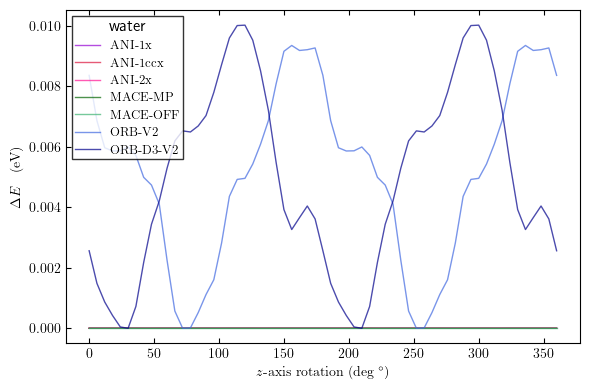

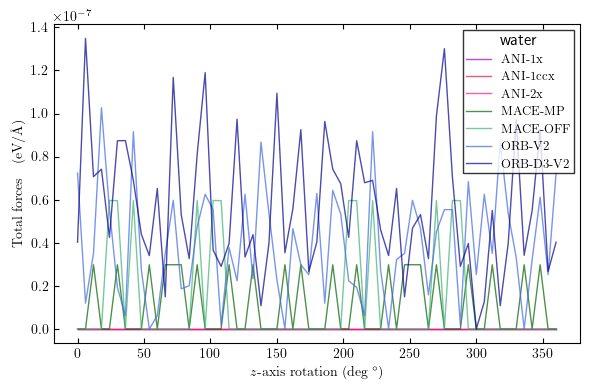

In [16]:
mol_name = 'water'
molecule = build.molecule('H2O')

evaluate_rotation(molecule, calculator_list, calc_name=CALC_NAME, mol_name=mol_name, compute_torque=False)

benzene
analyzing 60 rotationally different structures
using 7 models
scanning angles:
[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180. 186. 192. 198. 204. 210. 216. 222. 228. 234. 240. 246.
 252. 258. 264. 270. 276. 282. 288. 294. 300. 306. 312. 318. 324. 330.
 336. 342. 348. 354. 360.]
resulting energies:
[[-6317.903403291176, -6317.903400047327, -6317.903401061029, -6317.903402885695, -6317.903403696658, -6317.903402480214, -6317.903401871992, -6317.90340146651, -6317.903402074732, -6317.903402074732, -6317.903401871992, -6317.903402682954, -6317.903402277473, -6317.90340146651, -6317.903400047327, -6317.903402885695, -6317.903400047327, -6317.90340146651, -6317.903402277473, -6317.903402885695, -6317.903402074732, -6317.903401871992, -6317.903402074732, -6317.90340146651, -6317.903402074732, -6317.903402480214, -6317.903403493917, -6317.903402885695, -6317.903401061029, -631

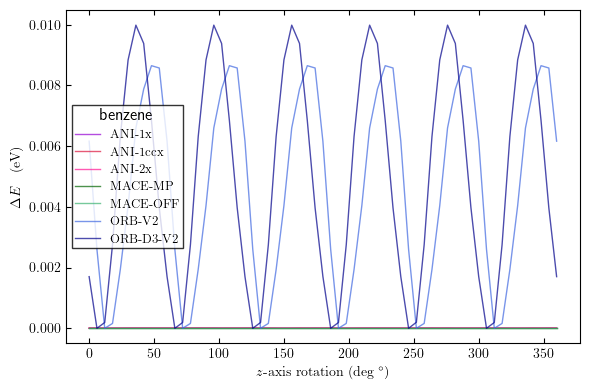

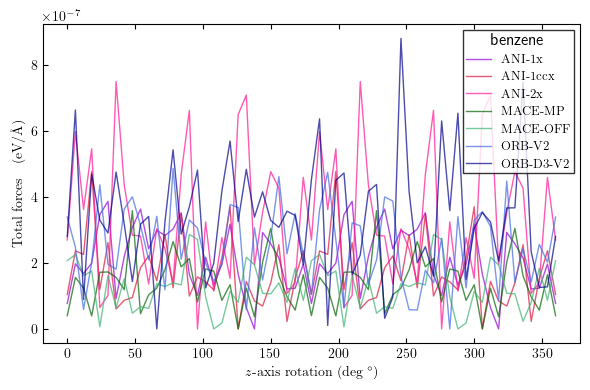

In [17]:
mol_name = 'benzene'
molecule = build.molecule('C6H6')

evaluate_rotation(molecule, calculator_list, calc_name=CALC_NAME, mol_name=mol_name)

ethanol
analyzing 60 rotationally different structures
using 7 models
scanning angles:
[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180. 186. 192. 198. 204. 210. 216. 222. 228. 234. 240. 246.
 252. 258. 264. 270. 276. 282. 288. 294. 300. 306. 312. 318. 324. 330.
 336. 342. 348. 354. 360.]
resulting energies:
[[-4217.496657955742, -4217.496657398206, -4217.496657499576, -4217.496657550261, -4217.496657499576, -4217.496656992725, -4217.496656942039, -4217.496657296836, -4217.496656992725, -4217.49665734752, -4217.496657448891, -4217.496657753002, -4217.496657094095, -4217.49665734752, -4217.496657550261, -4217.496657905058, -4217.496657296836, -4217.496657651632, -4217.496657550261, -4217.496657651632, -4217.496656992725, -4217.496656942039, -4217.496657296836, -4217.496657246151, -4217.496657195466, -4217.496657246151, -4217.496657854373, -4217.496656942039, -4217.49665734752, -42

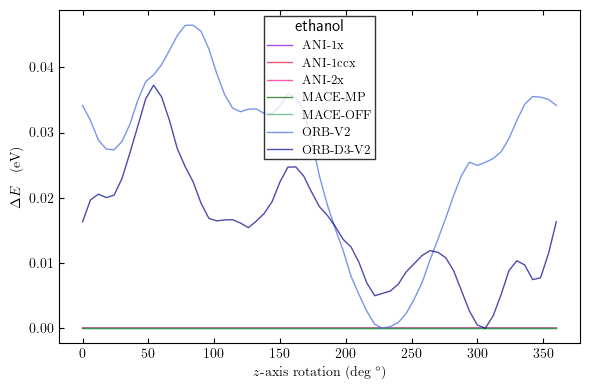

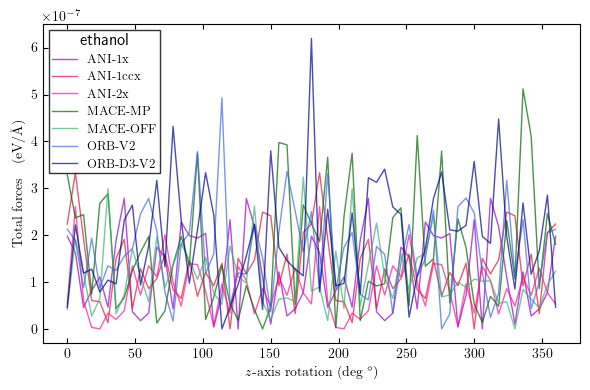

In [18]:
mol_name = 'ethanol'
molecule = build.molecule('CH3CH2OH')

evaluate_rotation(molecule, calculator_list, calc_name=CALC_NAME, mol_name=mol_name)

cosan
analyzing 180 rotationally different structures
using 7 models
scanning angles:
[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278.
 280. 282. 284. 286. 288. 290. 292. 294. 296. 298. 300. 302. 304. 306.
 308. 310. 312. 314. 316. 318. 320. 322. 324. 326. 328. 330. 332. 334.
 336. 338. 340. 342. 344. 346. 348. 350. 352. 354. 356. 358. 3

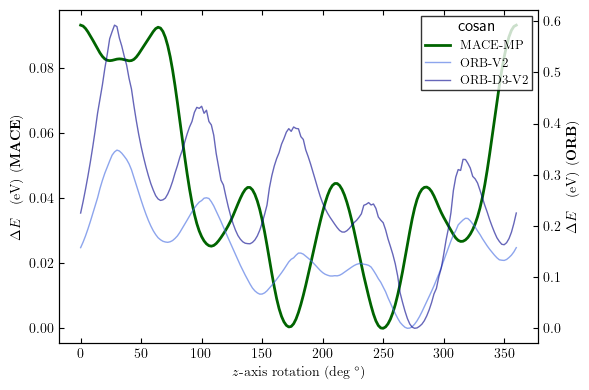

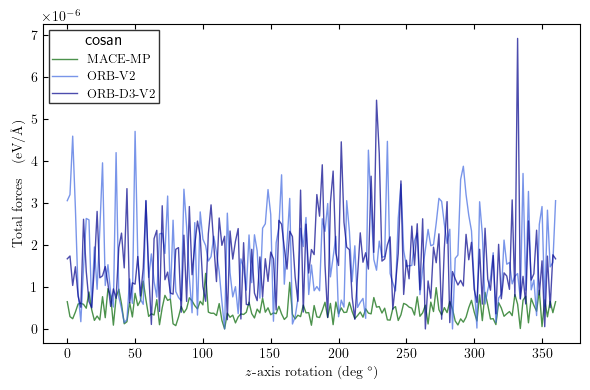

In [39]:
mol_name = 'cosan'
cosan_xyz = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/examples/COSAN/cosan.xyz'
cosan = read(cosan_xyz)

group = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
evaluate_rotation(cosan, calculator_list, calc_name=CALC_NAME, mol_name=mol_name, visualize=True, group=group, compute_torque=False, cosan=True, resolution=2)

In [ ]:
calculator_list = [macemp]
calculator_names = ['MACE-MP']
CALC_NAME='MACE-MP'

mol_name = 'cosan'
cosan_xyz = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/examples/COSAN/cosan.xyz'
cosan = read(cosan_xyz)

group = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
evaluate_rotation(cosan, calculator_list, calc_name=CALC_NAME, mol_name=mol_name, visualize=True, group=group, compute_torque=False, cosan=True, resolution=5)

In [ ]:
# visualize existing traj
work_dir = os.path.join(os.curdir, 'symmetries',  mol_name)
traj_path = os.path.join(work_dir, 'cosan_MACE-MP_rotation.traj')
traj = trajectory.TrajectoryReader(traj_path)

#write(os.path.join(work_dir, 'cosan_MACE-MP_rotation.xyz'), traj)
#view(traj, viewer='ase')

: 

## __TRANSLATION EXAMPLES__
Check if the energy changes in translations

using unit translation vector	[0.70710678 0.70710678 0.        ]
analyzing translationally different structures with resolution 0.2 Å
using 7 models
scanning total displacements:
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10. ]
resulting energies:
[[-4209.111482701035, -4209.111482396925, -4209.1114832078865, -4209.111482599665, -4209.111482701035, -4209.111482194184, -4209.111482802406, -4209.111482701035, -4209.111483106517, -4209.1114830051465, -4209.111481788703, -4209.111482498295, -4209.111482802406, -4209.111483309257, -4209.111483106517, -4209.111482599665, -4209.111482498295, -4209.111482194184, -4209.111482295554, -4209.1114830051465, -4209.111482903776, -4209.111483410627, -4209.111482903776, -4209.111482498295, -4209.111482903776, -4209.111483511998, -4209.1114813832

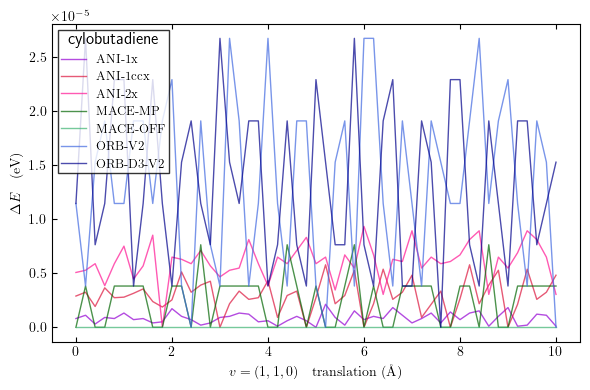

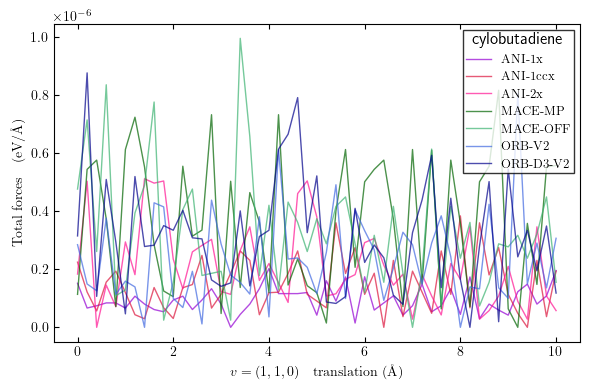

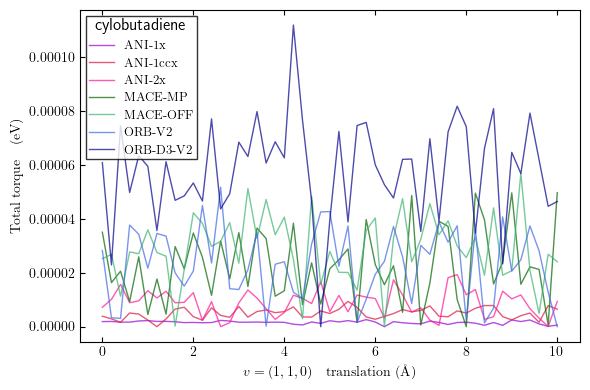

In [22]:
bond_ids_h = [0, 1]
mask_h = [0, 1, 0, 1, 0, 1, 0, 1]
bond_ids_v = [0, 2]
mask_v = [0, 0, 1, 1, 0, 0, 1, 1]

mol_name = 'cylobutadiene'
bond_name = 'CC'
molecule = pubchem_atoms_search(smiles='C1=CC=C1')

# set C-C distances
molecule.set_distance(bond_ids_h[0], bond_ids_h[1], 1.400000, fix=0, mask=mask_h)
molecule.set_distance(bond_ids_v[0], bond_ids_v[1], 1.400000, fix=0, mask=mask_v)

# set C-H distances
molecule.set_distance(0, 4, 1.08, fix=0)
molecule.set_distance(1, 5, 1.08, fix=0)
molecule.set_distance(2, 6, 1.08, fix=0)
molecule.set_distance(3, 7, 1.08, fix=0)


trans_vector = (1, 1, 0)
evaluate_translation(molecule, calculator_list, mol_name, calc_name=CALC_NAME, trans_vector=trans_vector, resolution=0.2, search_space=[0, 10], visualize=False)

using unit translation vector	[0.70710678 0.70710678 0.        ]
analyzing translationally different structures with resolution 0.2 Å
using 7 models
scanning total displacements:
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10. ]
resulting energies:
[[-2078.6371570369956, -2078.6371570369956, -2078.637157011653, -2078.6371570369956, -2078.6371569863104, -2078.637156960968, -2078.6371570369956, -2078.6371569863104, -2078.637157011653, -2078.6371569102826, -2078.6371569863104, -2078.6371570876804, -2078.637157011653, -2078.637157011653, -2078.6371570369956, -2078.6371570369956, -2078.6371570369956, -2078.637157011653, -2078.637157011653, -2078.6371571637083, -2078.637157113023, -2078.637157113023, -2078.637157113023, -2078.637157113023, -2078.637157113023, -2078.6371574424766, -2078

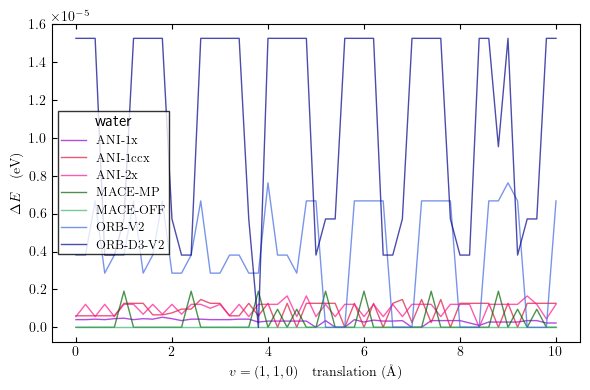

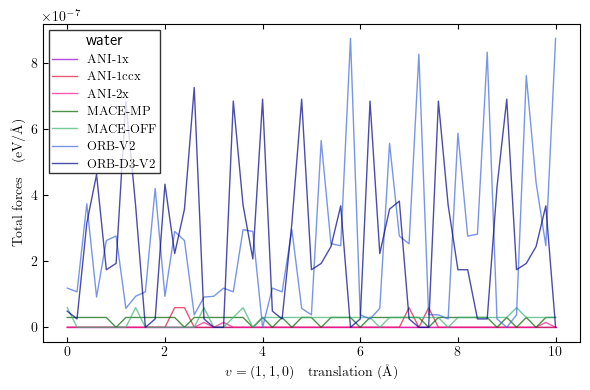

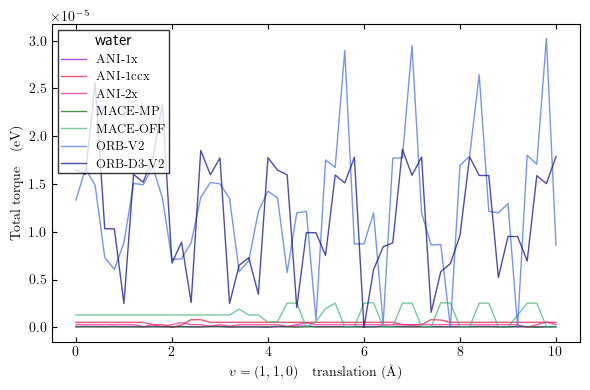

In [23]:
mol_name = 'water'
molecule = build.molecule('H2O')

trans_vector = (1, 1, 0)
evaluate_translation(molecule, calculator_list, mol_name, calc_name=CALC_NAME, trans_vector=trans_vector, resolution=0.2, search_space=[0, 10], visualize=False)

using unit translation vector	[0.70710678 0.70710678 0.        ]
analyzing translationally different structures with resolution 0.2 Å
using 7 models
scanning total displacements:
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10. ]
resulting energies:
[[-6317.903403291176, -6317.903401871992, -6317.903402885695, -6317.903402480214, -6317.903401871992, -6317.903401061029, -6317.903403088436, -6317.903401871992, -6317.903402277473, -6317.903402277473, -6317.903401871992, -6317.903402074732, -6317.903403088436, -6317.903402885695, -6317.903403291176, -6317.903402682954, -6317.903402074732, -6317.903402277473, -6317.903402682954, -6317.903402682954, -6317.903402277473, -6317.903402480214, -6317.903402480214, -6317.903403291176, -6317.903402682954, -6317.903402885695, -6317.903402885695,

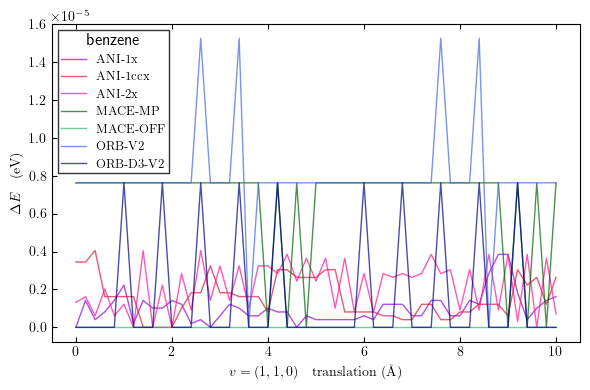

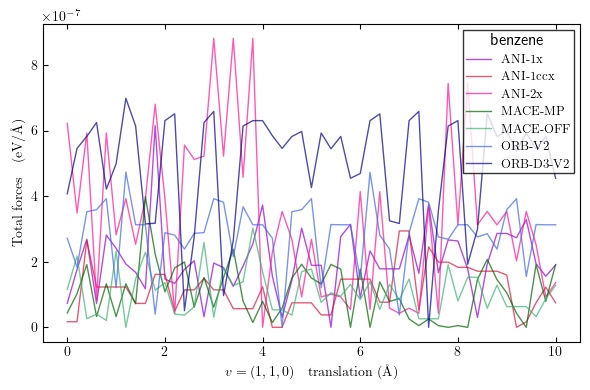

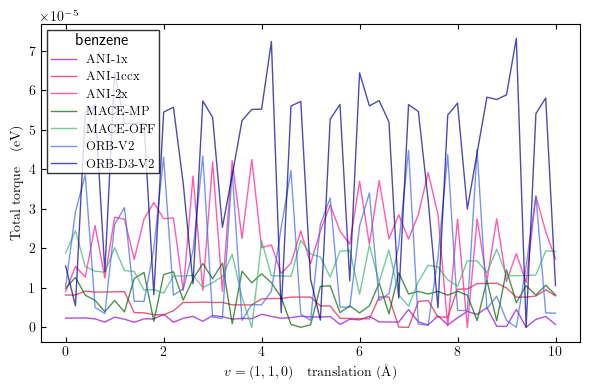

In [24]:
mol_name = 'benzene'
molecule = build.molecule('C6H6')

trans_vector = (1, 1, 0)
evaluate_translation(molecule, calculator_list, mol_name, calc_name=CALC_NAME, trans_vector=trans_vector, resolution=0.2, search_space=[0, 10], visualize=False)

using unit translation vector	[0.70710678 0.70710678 0.        ]
analyzing translationally different structures with resolution 0.2 Å
using 7 models
scanning total displacements:
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10. ]
resulting energies:
[[-4217.496657955742, -4217.496657499576, -4217.4966576009465, -4217.4966576009465, -4217.496657448891, -4217.496657651632, -4217.496657499576, -4217.496657398206, -4217.496657246151, -4217.496657550261, -4217.496657296836, -4217.496657651632, -4217.4966576009465, -4217.496657398206, -4217.496657854373, -4217.496657448891, -4217.496657499576, -4217.496656891354, -4217.496657499576, -4217.49665704341, -4217.496657651632, -4217.496657448891, -4217.49665714478, -4217.496657195466, -4217.496657550261, -4217.496657398206, -4217.496656840669

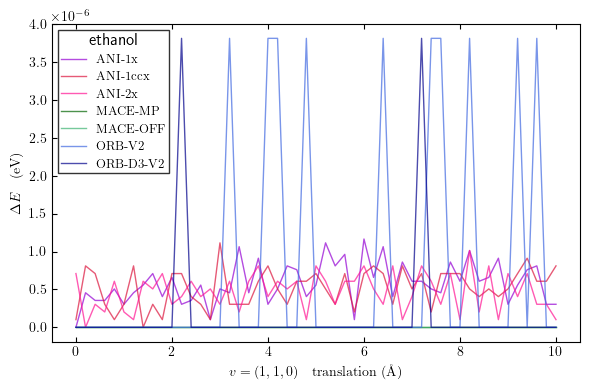

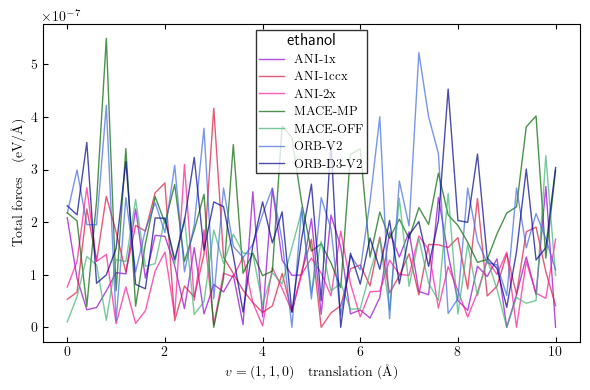

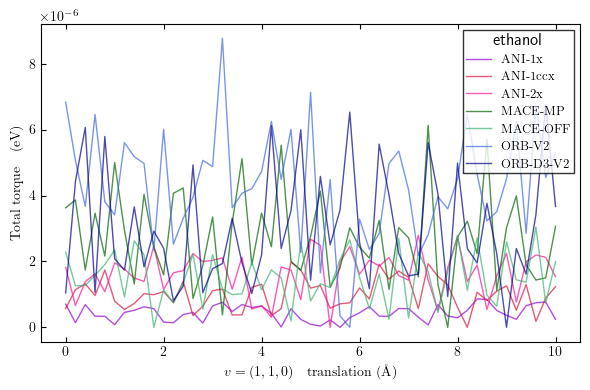

In [25]:
mol_name = 'ethanol'
molecule = build.molecule('CH3CH2OH')

trans_vector = (1, 1, 0)
evaluate_translation(molecule, calculator_list, mol_name, calc_name=CALC_NAME, trans_vector=trans_vector, resolution=0.2, search_space=[0, 10], visualize=True)

## __FORCE TESTING__
Test whether the net force on all the atoms of a given molecule is zero (suma de forces zero). 

In [26]:
molecule = build.molecule('H2O')
molecule.calc = orb_calc_v2

forces = np.array(molecule.get_forces())

f_vec = forces.sum(axis=0)
f_scalar = np.sqrt(f_vec.dot(f_vec))

## __TORQUE TESTING__

Test whether the net torque is zero (moment de forces zero). The procedure is as follows, compute the center of mass, compute the torques on each particle and add them together. The molecule is centered on the center of mass such that M_R = (0, 0, 0). Torque defined wrt the center of mass. 

These are the classical (rigid body) stationary conditions.

In [27]:
molecule = build.molecule('CH3CH2OH')
molecule.calc = orb_calc_d3_v2

# per defecte ja està centrat en el center of mass
com = molecule.get_center_of_mass()
print(f'initial com\t{com}')

pos = np.array(molecule.get_positions())
forces = np.array(molecule.get_forces())

torques = []
for i in range(len(pos)):
    tau = np.cross(pos[i], forces[i])
    torques.append(tau)
total_tau = np.array(torques).sum()
print(f'total torque\t{total_tau}')


molecule.center(about=com)
com = molecule.get_center_of_mass()

pos = np.array(molecule.get_positions())
forces = np.array(molecule.get_forces())

print(f'final com after centering\t{com}')


torques = []
for i in range(len(pos)):
    tau = np.cross(pos[i], forces[i])
    torques.append(tau)

total_tau = np.array(torques).sum()
print(f'total torque after centering\t{total_tau}')

initial com	[-5.37767975e-02 -1.86233360e-02  7.30935462e-19]
total torque	-6.24481940603161e-08
final com after centering	[-1.92187595e-01 -1.22383672e-01  7.30935462e-19]
total torque after centering	6.669226297606468e-08
